In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import ast
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, log_loss
import joblib
from sklearn.model_selection import GridSearchCV

# **Анализ данных**

## Загружаем датасеты и визуализируем их

In [2]:
geo_info = pd.read_csv('geo_info.csv', delimiter=';')
referer_vectors = pd.read_csv('referer_vectors.csv', delimiter=';')
test = pd.read_csv('test_3.csv', delimiter=';')
test_users = pd.read_csv('test_users.csv', delimiter=';')
train = pd.read_csv('train_3.csv', delimiter=';')
train_labels = pd.read_csv('train_labels.csv', delimiter=';')

In [3]:
print("train_labels:")
display(train_labels.head())
print("\ntrain:")
display(train.head())
print("\nreferer_vectors:")
display(referer_vectors.head())
print("\ngeo_info:")
display(geo_info.head())

train_labels:


,user_id,target
0,fb858e8e0a2bec074450eaf94b627fd3,0
1,46a5f128fd569c764a92c2eaa788095e,0
2,5a74e9ac53ffb21a20cce117c0ad77ba,0
3,af735816ca19115431ae3d89518c8c91,0
4,364f0ae0a3f29a685c4fb5bae6033b9a,0



train:


,request_ts,user_id,referer,geo_id,user_agent
0,1701011363,fb858e8e0a2bec074450eaf94b627fd3,https://9b48ee5/,4799,"{'browser': 'Chrome Mobile', 'browser_version'..."
1,1700986581,46a5f128fd569c764a92c2eaa788095e,https://9b48ee5/,8257,"{'browser': 'Chrome Mobile', 'browser_version'..."
2,1701011071,5a74e9ac53ffb21a20cce117c0ad77ba,https://9634fd0/1409e548,3150,"{'browser': 'Yandex Browser', 'browser_version..."
3,1700992803,af735816ca19115431ae3d89518c8c91,https://9b48ee5/,2740,"{'browser': 'Chrome Mobile', 'browser_version'..."
4,1701021666,364f0ae0a3f29a685c4fb5bae6033b9a,https://9b48ee5/,4863,"{'browser': 'Yandex Browser', 'browser_version..."



referer_vectors:


,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,referer
0,16708,-3741,11395,-1597,-3212,6269,5610,-15351,13779,14102,https://a6899a4/15652e67
1,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,https://9b48ee5/
2,10551,2947,12282,-470,16222,4472,-3316,9606,4197,18948,https://7a4c700/161af7e3
3,12816,20498,-10110,7731,-569,12035,3014,6398,11439,-271,https://9653126/159bc361
4,3710,11096,11333,14673,8030,1852,10554,11625,4306,13210,https://72879b4/125c29e6



geo_info:


,geo_id,country_id,region_id,timezone_id
0,6447,c31b4e,470e75,f6155e
1,8730,a0a6e9,NaN,d816ca
2,7769,e878d4,NaN,ec4385
3,7330,c31b4e,23f9c2,f6155e
4,600,c31b4e,6dbc37,e56e80


## Смотрим: сбалансированны ли наши данные?


Распределение пола:
target
0    0.52304
1    0.47696
Name: proportion, dtype: float64


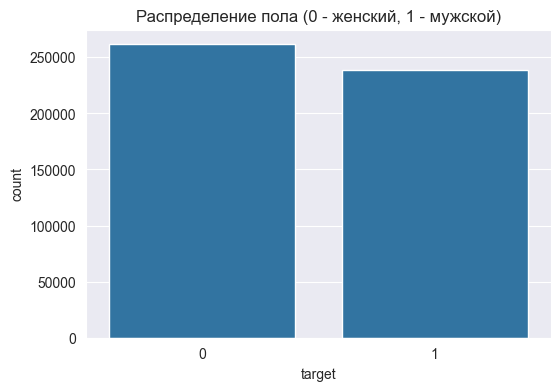

In [4]:
print('\nРаспределение пола:')
print(train_labels['target'].value_counts(normalize=True))

plt.figure(figsize=(6, 4))
sns.countplot(data=train_labels, x='target')
plt.title('Распределение пола (0 - женский, 1 - мужской)')
plt.show()

Распределение пола выглядит сбалансированным. Учтём это при обучении модели.

## Анализируем влияние времени на активность пользователей разного пола

Делаем одинаковые временные метки для train и test

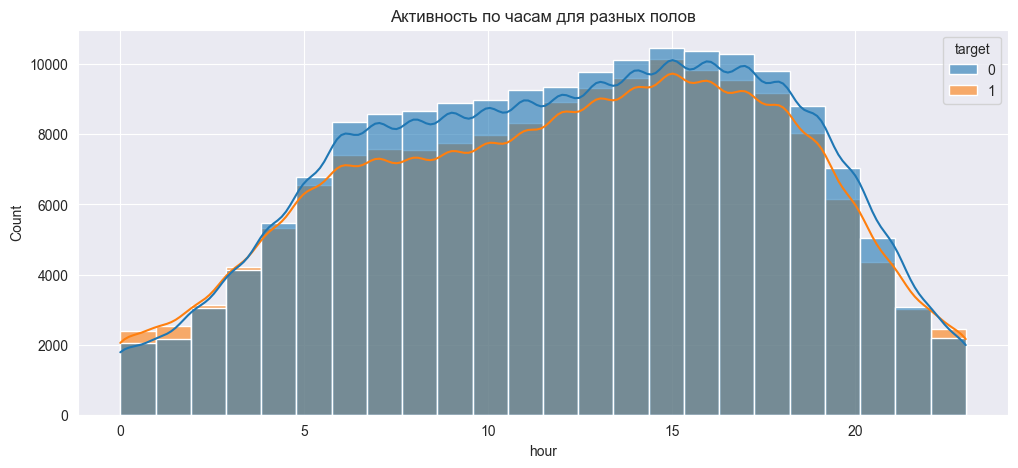

In [5]:
train = pd.DataFrame(train)
train['datetime'] = pd.to_datetime(train['request_ts'], unit='s')

train['hour'] = train['datetime'].dt.hour
train['day_of_week'] = train['datetime'].dt.dayofweek
train['date'] = train['datetime'].dt.date

test = pd.DataFrame(test)
test['datetime'] = pd.to_datetime(test['request_ts'], unit='s')

test['hour'] = test['datetime'].dt.hour
test['day_of_week'] = test['datetime'].dt.dayofweek
test['date'] = test['datetime'].dt.date

train_with_target = train.merge(train_labels, on='user_id')

# График активности по часам для каждого пола
plt.figure(figsize=(12, 5))
sns.histplot(data=train_with_target, x='hour', hue='target', bins=24, kde=True, alpha=0.6)
plt.title("Активность по часам для разных полов")
plt.show()

## Анализ геоданных


Топ-5 стран:
country_id
c31b4e     272464
121db33     16069
af12ca       9175
ac5671       4639
b98648       4613
Name: count, dtype: int64


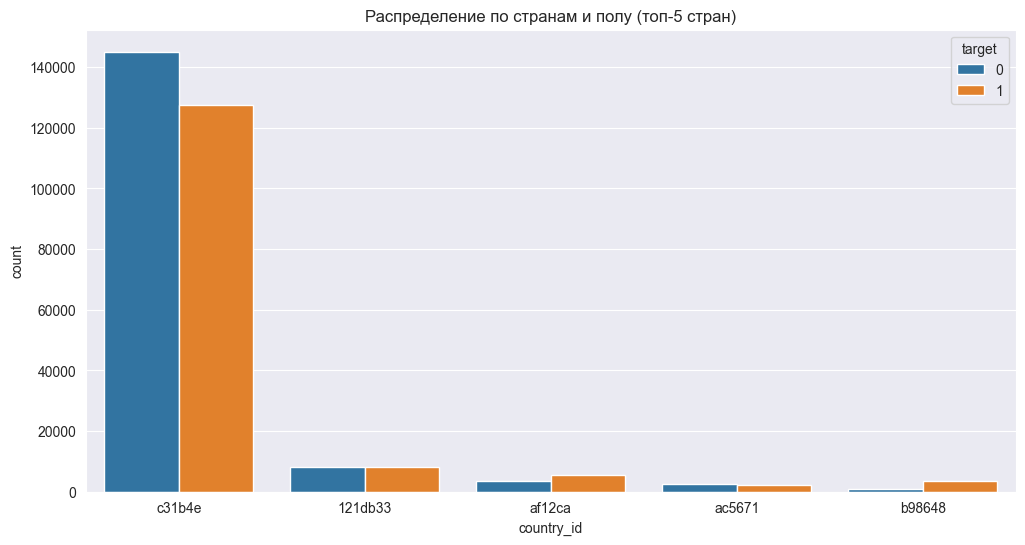

In [6]:
train_with_geo = train_with_target.merge(geo_info, on='geo_id', how='left')

top_countries = train_with_geo['country_id'].value_counts().head(5)
print("\nТоп-5 стран:")
print(top_countries)

plt.figure(figsize=(12, 6))
sns.countplot(data=train_with_geo, x='country_id', hue='target',
             order=train_with_geo['country_id'].value_counts().iloc[:5].index)
plt.title("Распределение по странам и полу (топ-5 стран)")
plt.show()

## Анализ браузеров и ОС

In [7]:
# Функция для безопасного преобразования строки в словарь
def parse_user_agent(ua_str):
    try:
        return ast.literal_eval(ua_str)
    except:
        return {'browser': 'unknown', 'os': 'unknown'}

train_with_target['user_agent_dict'] = train_with_target['user_agent'].apply(parse_user_agent)

# Создаём отдельные колонки
train_with_target['browser'] = train_with_target['user_agent_dict'].apply(lambda x: x.get('browser', 'unknown'))
train_with_target['browser_version'] = train_with_target['user_agent_dict'].apply(lambda x: x.get('browser_version', 'unknown'))
train_with_target['os'] = train_with_target['user_agent_dict'].apply(lambda x: x.get('os', 'unknown'))
train_with_target['os_version'] = train_with_target['user_agent_dict'].apply(lambda x: x.get('os_version', 'unknown'))

print("\nРаспределение браузеров:")
print(train_with_target['browser'].value_counts(normalize=True).head(10))

print("\nРаспределение операционных систем:")
print(train_with_target['os'].value_counts(normalize=True).head(10))

browser_by_gender = train_with_target.groupby(['target', 'browser']).size().unstack().fillna(0)
os_by_gender = train_with_target.groupby(['target', 'os']).size().unstack().fillna(0)

print("\nБраузеры по полу:")
display(browser_by_gender)

print("\nОС по полу:")
display(os_by_gender)


Распределение браузеров:
browser
Chrome Mobile            0.378936
Chrome                   0.256254
Yandex Browser           0.176599
Chrome Mobile WebView    0.044987
YandexSearch             0.030899
Edge                     0.025718
Opera                    0.022640
Mobile Safari            0.019883
Firefox                  0.008996
MiuiBrowser              0.008436
Name: proportion, dtype: float64

Распределение операционных систем:
os
Android          0.706488
Windows          0.246926
iOS              0.030738
Mac OS X         0.009214
Linux            0.005086
Tizen            0.001084
Chrome OS        0.000216
Ubuntu           0.000174
Windows Phone    0.000027
Other            0.000021
Name: proportion, dtype: float64

Браузеры по полу:


browser,Amazon Silk,Android,Apple Mail,Bot,Bytespider,Chrome,Chrome Mobile,Chrome Mobile WebView,Chrome Mobile iOS,Chromium,...,Sogou Explorer,UC Browser,Vivaldi,Waterfox,WebKit Nightly,Whale,Yandex Browser,YandexModule2,YandexSearch,unknown
target,,,,,,,,,,,,,,,,,,,,,
0,7.0,3.0,1.0,0.0,1.0,43419.0,63496.0,11819.0,287.0,0.0,...,0.0,33.0,1.0,0.0,3.0,0.0,31137.0,2.0,2333.0,1.0
1,7.0,0.0,5.0,2.0,0.0,42183.0,63088.0,3209.0,325.0,2.0,...,1.0,89.0,1.0,1.0,0.0,1.0,27856.0,11.0,7989.0,1.0



ОС по полу:


os,Android,Chrome OS,Chromecast,FreeBSD,Linux,Mac OS X,Other,Tizen,Ubuntu,Windows,Windows Phone,iOS,unknown
target,,,,,,,,,,,,,
0,123593.0,42.0,1.0,0.0,641.0,1508.0,3.0,148.0,41.0,39504.0,4.0,7167.0,1.0
1,112410.0,30.0,2.0,4.0,1058.0,1570.0,4.0,214.0,17.0,42982.0,5.0,3101.0,1.0


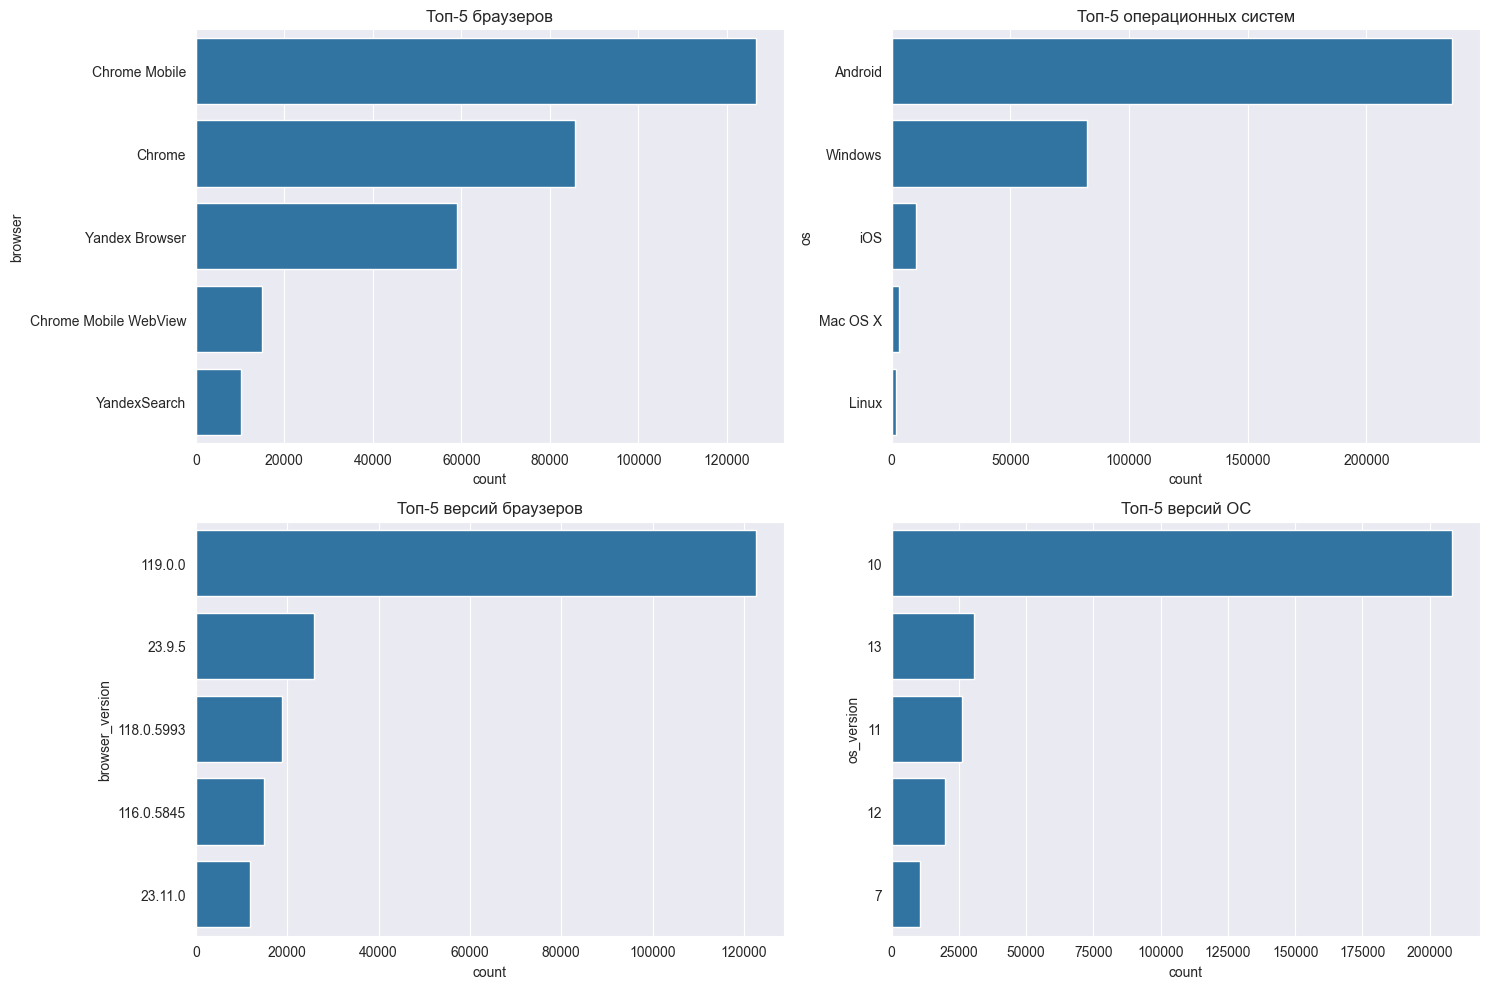

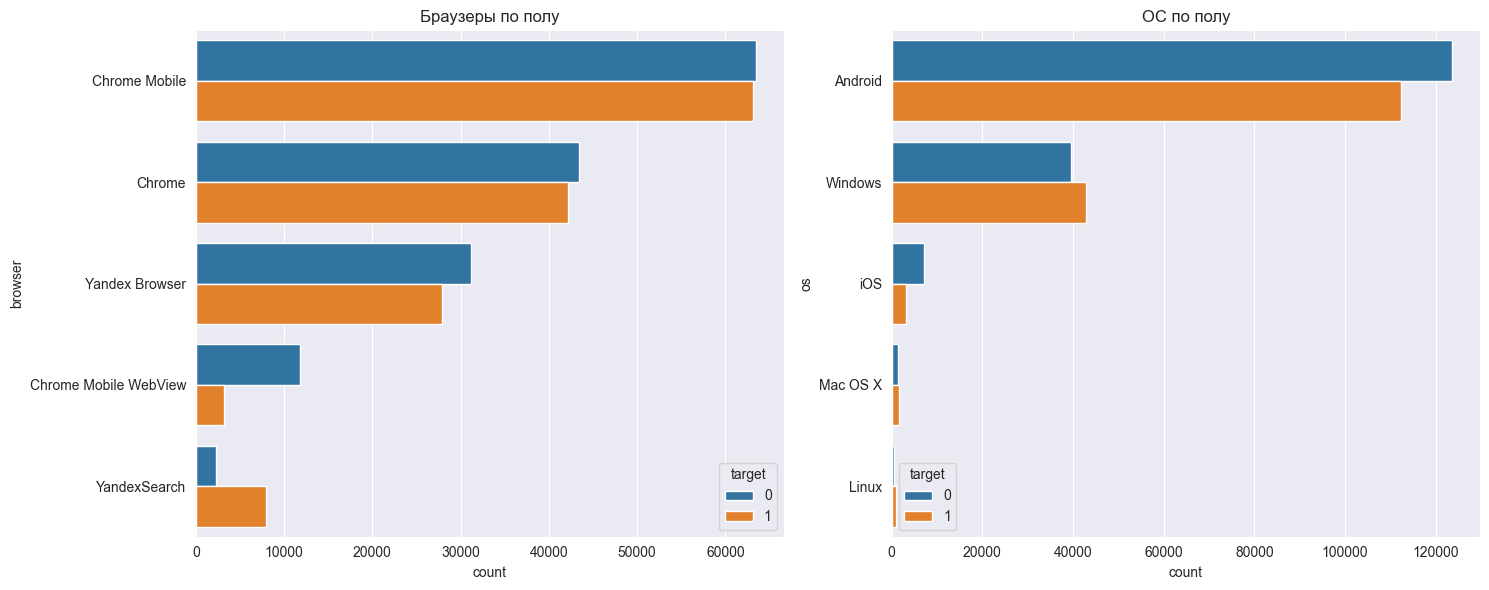


Доля мобильных устройств по полу:
target
0    0.757357
1    0.715690
Name: is_mobile, dtype: float64

Топ-10 комбинаций браузер/ОС:
browser                os     
Chrome Mobile          Android    126583
Chrome                 Android     48975
                       Windows     33922
Yandex Browser         Windows     29590
                       Android     27840
Chrome Mobile WebView  Android     15009
YandexSearch           Android     10322
Edge                   Windows      8585
Opera                  Windows      7291
Mobile Safari          iOS          6642
dtype: int64

Уникальные версии браузеров:
browser
Yandex Browser                273
YandexSearch                  117
Chrome Mobile                 115
Chrome                        109
MiuiBrowser                   105
Opera                         101
Opera Mobile                   91
Chrome Mobile WebView          71
Google                         65
Firefox                        62
Mobile Safari                  53
F

In [8]:
top_browsers = train_with_target['browser'].value_counts().nlargest(5).index
top_os = train_with_target['os'].value_counts().nlargest(5).index
top_browser_versions = train_with_target['browser_version'].value_counts().nlargest(5).index
top_os_versions = train_with_target['os_version'].value_counts().nlargest(5).index

plt.figure(figsize=(15, 10))

# Браузеры
plt.subplot(2, 2, 1)
sns.countplot(data=train_with_target[train_with_target['browser'].isin(top_browsers)],
             y='browser', order=top_browsers)
plt.title('Топ-5 браузеров')

# ОС
plt.subplot(2, 2, 2)
sns.countplot(data=train_with_target[train_with_target['os'].isin(top_os)],
             y='os', order=top_os)
plt.title('Топ-5 операционных систем')

# Версии браузеров
plt.subplot(2, 2, 3)
sns.countplot(data=train_with_target[train_with_target['browser_version'].isin(top_browser_versions)],
             y='browser_version', order=top_browser_versions)
plt.title('Топ-5 версий браузеров')

# Версии ОС
plt.subplot(2, 2, 4)
sns.countplot(data=train_with_target[train_with_target['os_version'].isin(top_os_versions)],
             y='os_version', order=top_os_versions)
plt.title('Топ-5 версий ОС')

plt.tight_layout()
plt.show()

# Анализ по полу
plt.figure(figsize=(15, 6))

# Браузеры по полу
plt.subplot(1, 2, 1)
sns.countplot(data=train_with_target[train_with_target['browser'].isin(top_browsers)],
             y='browser', hue='target', order=top_browsers)
plt.title('Браузеры по полу')

# ОС по полу
plt.subplot(1, 2, 2)
sns.countplot(data=train_with_target[train_with_target['os'].isin(top_os)],
             y='os', hue='target', order=top_os)
plt.title('ОС по полу')

plt.tight_layout()
plt.show()

# Мобильные устройства по полу
train_with_target['is_mobile'] = train_with_target['os'].isin(['Android', 'iOS'])
mobile_by_gender = train_with_target.groupby('target')['is_mobile'].mean()
print("\nДоля мобильных устройств по полу:")
print(mobile_by_gender)

# Дополнительная статистика
print("\nТоп-10 комбинаций браузер/ОС:")
print(train_with_target.groupby(['browser', 'os']).size().sort_values(ascending=False).head(10))

print("\nУникальные версии браузеров:")
print(train_with_target.groupby('browser')['browser_version'].nunique().sort_values(ascending=False))

# Предобработка данных

## Анализ пропусков в данных

In [9]:
print("Информация про geo_info:")
print(geo_info.info())
print('\nИнформация про referer_vectors:')
print(referer_vectors.info())
print('\nИнформация про test:')
print(test.info())
print('\nИнформация про test_users:')
print(test_users.info())
print('\nИнформация про train:')
print(train.info())
print('\nИнформация про train_labels:')
print(train_labels.info())

Информация про geo_info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5533 entries, 0 to 5532
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   geo_id       5533 non-null   int64 
 1   country_id   5533 non-null   object
 2   region_id    3826 non-null   object
 3   timezone_id  5533 non-null   object
dtypes: int64(1), object(3)
memory usage: 173.0+ KB
None

Информация про referer_vectors:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   component0  200000 non-null  int64 
 1   component1  200000 non-null  int64 
 2   component2  200000 non-null  int64 
 3   component3  200000 non-null  int64 
 4   component4  200000 non-null  int64 
 5   component5  200000 non-null  int64 
 6   component6  200000 non-null  int64 
 7   component7  200000 non-null  int64 
 8   compone

### Заполняем пропуски

In [10]:
train['user_agent'] = train['user_agent'].fillna("{'browser': 'unknown', 'os': 'unknown'}")
# Заполняем пропуски в region_id
geo_info['region_id'] = geo_info['region_id'].fillna('unknown_region')

# Проверяем уникальные значения country_id и timezone_id
print("Уникальные country_id:", geo_info['country_id'].nunique())
print("Уникальные timezone_id:", geo_info['timezone_id'].nunique())

# Проверяем соответствие referer между train и referer_vectors
train_referers = set(train['referer'].unique())
vectors_referers = set(referer_vectors['referer'].unique())
missing_in_vectors = train_referers - vectors_referers

if missing_in_vectors:
    print(f"Добавляем {len(missing_in_vectors)} отсутствующих referer в вектора")
    # Создаем нулевые вектора для отсутствующих URL
    new_vectors = pd.DataFrame({
        'referer': list(missing_in_vectors),
        **{f'component{i}': [0] * len(missing_in_vectors) for i in range(10)}
    })
    referer_vectors = pd.concat([referer_vectors, new_vectors])

# Проверяем соответствие geo_id с geo_info
test_geo_missing = set(test['geo_id']) - set(geo_info['geo_id'])
if test_geo_missing:
    print(f"Добавляем {len(test_geo_missing)} отсутствующих geo_id")
    # Создаем записи с дефолтными значениями
    new_geo = pd.DataFrame({
        'geo_id': list(test_geo_missing),
        'country_id': ['unknown_country'] * len(test_geo_missing),
        'region_id': ['unknown_region'] * len(test_geo_missing),
        'timezone_id': ['UTC'] * len(test_geo_missing)
    })
    geo_info = pd.concat([geo_info, new_geo])

print("\nПроверка пропусков после обработки: ")
print("train user_agent:", train['user_agent'].isnull().sum())
print("geo_info region_id:", geo_info['region_id'].isnull().sum())
print("referer_vectors:", referer_vectors.isnull().sum().sum())
print("test:", test.isnull().sum().sum())

Уникальные country_id: 203
Уникальные timezone_id: 314

Проверка пропусков после обработки: 
train user_agent: 0
geo_info region_id: 0
referer_vectors: 0
test: 0


### Объединяем данные

In [11]:
train_enriched = train.merge(geo_info, on='geo_id', how='left')
train_enriched = train_enriched.merge(referer_vectors, on='referer', how='left')

# **Feature Engineering**

## Функции для создания дополнительных признаков, выявленных во время анализа

In [12]:
def create_time_features(df):
    time_features = df.groupby('user_id').agg({
        'hour': [
            ('night_activity', lambda x: x.isin([23, 0, 1, 2, 3]).mean()),
            ('activity_std', 'std')
        ],
        'day_of_week': [
            ('is_weekend', lambda x: x.isin([5, 6]).mean())
        ]
    })
    time_features.columns = ['_'.join(col).strip() for col in time_features.columns.values]
    return time_features.reset_index()

In [13]:
def create_geo_features(df):
    geo_features = df.groupby('user_id').agg({
        'country_id': [
            ('unique_countries', 'nunique'),
            ('main_country', lambda x: x.mode()[0])
        ],
        'timezone_id': [('timezone_changes', 'nunique')]
    })
    geo_features.columns = ['_'.join(col).strip() for col in geo_features.columns.values]
    return geo_features.reset_index()

In [14]:
def create_device_features(df):
    df['ua_dict'] = df['user_agent'].apply(parse_user_agent)
    df['browser'] = df['ua_dict'].apply(lambda x: x.get('browser', 'unknown'))
    df['os'] = df['ua_dict'].apply(lambda x: x.get('os', 'unknown'))

    device_features = df.groupby('user_id').agg({
        'browser': [
            ('unique_browsers', 'nunique'),
            ('main_browser', lambda x: x.mode()[0])  # Самый частый браузер
        ],
        'os': [
            ('is_mobile', lambda x: (x.isin(['Android', 'iOS'])).mean())  # Доля мобильных ОС
        ]
    })

    device_features.columns = ['_'.join(col).strip() for col in device_features.columns.values]
    return device_features.reset_index()

In [15]:
def create_activity_features(df):
    df['domain'] = df['referer'].str.split('/').str[2]

    activity_features = df.groupby('user_id').agg({
    'domain': [
        ('unique_domains', 'nunique'),
        ('main_domain', lambda x: x.mode()[0])
    ],
    **{
        f'component{i}': ['mean', 'std']
        for i in range(10)
    }
    })
    activity_features.columns = ['_'.join(col).strip() for col in activity_features.columns.values]
    return activity_features.reset_index()

In [16]:
# Создаем признаки
time_features = create_time_features(train_enriched)
geo_features = create_geo_features(train_enriched)
device_features = create_device_features(train_enriched)
activity_features = create_activity_features(train_enriched, )

# Объединяем
final_features = (
    time_features
    .merge(geo_features, on='user_id', how='left')
    .merge(device_features, on='user_id', how='left')
    .merge(activity_features, on='user_id', how='left')
    .merge(train_labels, on='user_id', how='left')
)

## Обрабатываем категориальные данные

In [17]:
# Сохраняем маппинги для target encoding
mean_target_dict = {}
for col in ['country_id_main_country', 'domain_main_domain']:
    mean_target_dict[col] = final_features.groupby(col)['target'].mean()

# Сохраняем обученный LabelEncoder для браузеров
label_encoder_browser = LabelEncoder()
final_features['browser_main_browser_encoded'] = label_encoder_browser.fit_transform(
    final_features['browser_main_browser']
)

# Target Encoding для стран и доменов
for col in ['country_id_main_country', 'domain_main_domain']:
    # Вычисляем средний target для каждой категории
    mean_target = final_features.groupby(col)['target'].mean()

    # Создаем новый признак
    final_features[f'{col}_encoded'] = final_features[col].map(mean_target)

    # Заполняем пропуски средним значением target (если появятся новые категории)
    final_features[f'{col}_encoded'].fillna(final_features['target'].mean(), inplace=True)

# Label Encoding для браузеров
final_features['browser_main_browser_encoded'] = LabelEncoder().fit_transform(
    final_features['browser_main_browser']
)

# Удаляем исходные категориальные колонки
cols_to_drop = ['country_id_main_country', 'domain_main_domain', 'browser_main_browser']
final_features.drop(cols_to_drop, axis=1, inplace=True, errors='ignore')

## Изучаем влияние признаков и удаляем лишние

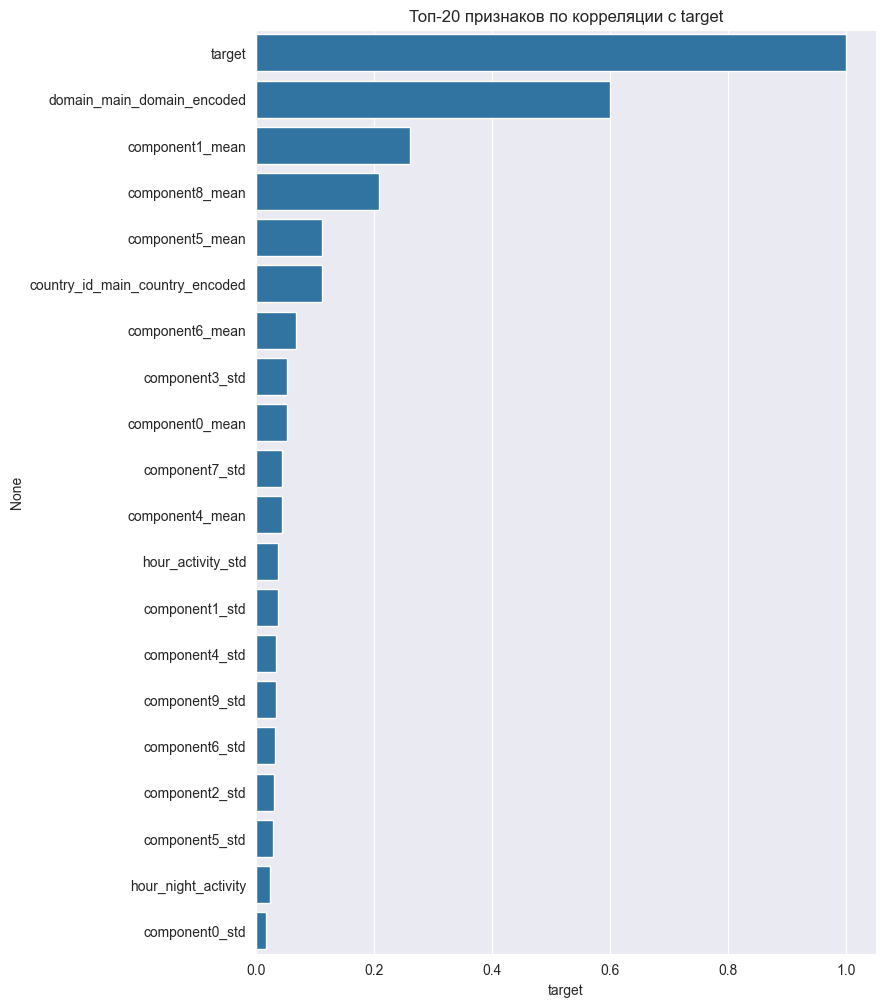

In [18]:
# Вычисляем корреляцию всех признаков с target
corr_with_target = final_features.select_dtypes(include=['float64', 'int64']).corr()[['target']].sort_values('target', ascending=False)

plt.figure(figsize=(8, 12))
sns.barplot(x=corr_with_target['target'].head(20), y=corr_with_target.head(20).index)
plt.title('Топ-20 признаков по корреляции с target')
plt.show()

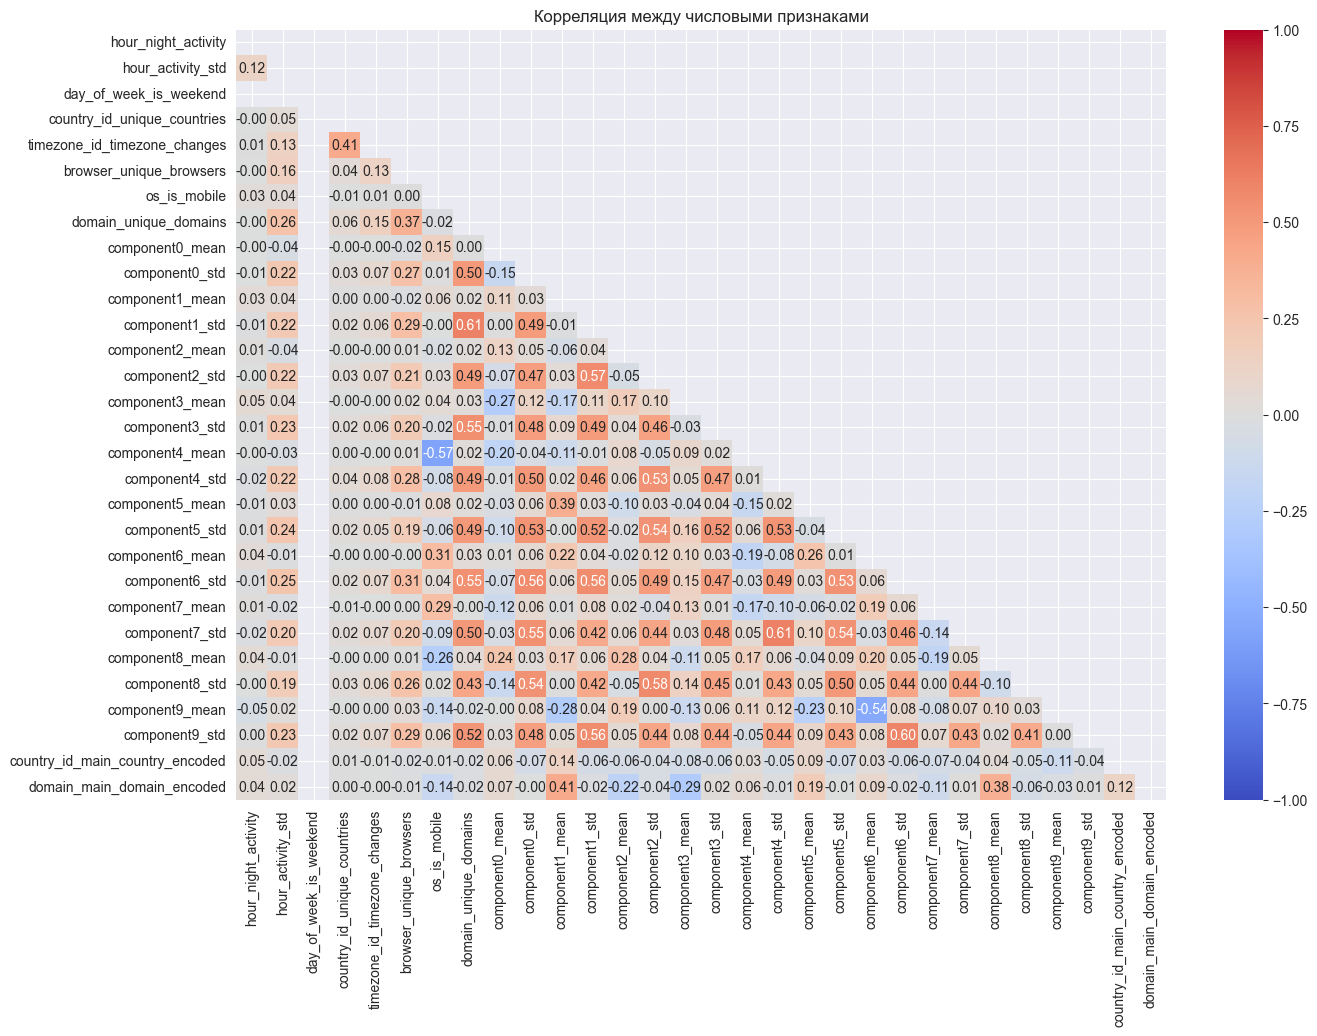

In [19]:
# Выделим только числовые признаки
num_features = final_features.select_dtypes(include=['float64', 'int64']).columns

# Исключим target из анализа корреляций
if 'target' in num_features:
    num_features = num_features.drop('target')

# Построим тепловую карту
if len(num_features) > 0:
    plt.figure(figsize=(15, 10))
    sns.heatmap(
        final_features[num_features].corr(),
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        center=0,
        vmin=-1,
        vmax=1,
        mask=np.triu(np.ones_like(final_features[num_features].corr()))
    )
    plt.title('Корреляция между числовыми признаками')
    plt.show()
else:
    print("Нет числовых признаков для анализа корреляции")

In [20]:
# Пороговые значения
TARGET_CORR_THRESHOLD = 0.02  # Минимальная корреляция с target
FEATURE_CORR_THRESHOLD = 0.8   # Максимальная допустимая корреляция между признаками

# Удаляем признаки с низкой корреляцией с target
existing_features = set(final_features.columns)
low_corr_features = [col for col in corr_with_target[abs(corr_with_target['target']) < TARGET_CORR_THRESHOLD].index
                 if col in existing_features]

final_features_reduced = final_features.drop(low_corr_features, axis=1, errors='ignore')

# Удаляем высоко коррелирующие признаки
num_features = [col for col in final_features_reduced.select_dtypes(include=['float64', 'int64']).columns
               if col != 'target']

if num_features:
    corr_matrix = final_features_reduced[num_features].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns
               if any(upper[column] > FEATURE_CORR_THRESHOLD)]

    to_drop = [col for col in to_drop if col in final_features_reduced.columns]

    final_features_reduced = final_features_reduced.drop(to_drop, axis=1)
else:
    to_drop = []
    print("Нет числовых признаков для анализа корреляции")

print(f"Удалено {len(low_corr_features)} признаков с низкой корреляцией с target: {low_corr_features}")
print(f"Удалено {len(to_drop)} признаков из-за высокой корреляции: {to_drop}")
print(f"Итоговое количество признаков: {len(final_features_reduced.columns)}")
print("Оставшиеся признаки:", final_features_reduced.columns.tolist())

Удалено 6 признаков с низкой корреляцией с target: ['component0_std', 'domain_unique_domains', 'browser_unique_browsers', 'timezone_id_timezone_changes', 'country_id_unique_countries', 'component9_mean']
Удалено 0 признаков из-за высокой корреляции: []
Итоговое количество признаков: 27
Оставшиеся признаки: ['user_id', 'hour_night_activity', 'hour_activity_std', 'day_of_week_is_weekend', 'os_is_mobile', 'component0_mean', 'component1_mean', 'component1_std', 'component2_mean', 'component2_std', 'component3_mean', 'component3_std', 'component4_mean', 'component4_std', 'component5_mean', 'component5_std', 'component6_mean', 'component6_std', 'component7_mean', 'component7_std', 'component8_mean', 'component8_std', 'component9_std', 'target', 'browser_main_browser_encoded', 'country_id_main_country_encoded', 'domain_main_domain_encoded']


In [21]:
print(final_features_reduced.isnull().sum())
print(final_features_reduced.dtypes)

user_id                                 0
hour_night_activity                     0
hour_activity_std                  269723
day_of_week_is_weekend                  0
os_is_mobile                            0
component0_mean                         0
component1_mean                         0
component1_std                     269723
component2_mean                         0
component2_std                     269723
component3_mean                         0
component3_std                     269723
component4_mean                         0
component4_std                     269723
component5_mean                         0
component5_std                     269723
component6_mean                         0
component6_std                     269723
component7_mean                         0
component7_std                     269723
component8_mean                         0
component8_std                     269723
component9_std                     269723
target                            

Заполняем пропуски в признаках с std

In [22]:
std_cols = [col for col in final_features_reduced.columns if '_std' in col]
final_features_reduced[std_cols] = final_features_reduced[std_cols].fillna(0)

# Запоминаем список финальных колонок
final_columns = [c for c in final_features_reduced.columns if c != 'target']

print(final_features_reduced[std_cols].isnull().sum())

hour_activity_std    0
component1_std       0
component2_std       0
component3_std       0
component4_std       0
component5_std       0
component6_std       0
component7_std       0
component8_std       0
component9_std       0
dtype: int64


Сохраняем финальный файл для обучения

In [23]:
final_features_reduced.to_parquet('final_dataset_for_training.parquet')

## Обрабатываем тестовые данные также, как и данные для обучения

In [24]:
# Заполняем пропуски как в train
test['user_agent'] = test['user_agent'].fillna("{'browser': 'unknown', 'os': 'unknown'}")
geo_info['region_id'] = geo_info['region_id'].fillna('unknown_region')

# Проверяем referer_vectors
test_referers = set(test['referer'].unique())
vectors_referers = set(referer_vectors['referer'].unique())
missing_in_vectors = test_referers - vectors_referers

if missing_in_vectors:
    print(f"Добавляем {len(missing_in_vectors)} отсутствующих referer в вектора")
    new_vectors = pd.DataFrame({
        'referer': list(missing_in_vectors),
        **{f'component{i}': [0] * len(missing_in_vectors) for i in range(10)}
    })
    referer_vectors = pd.concat([referer_vectors, new_vectors])

# Проверяем geo_info
test_geo_missing = set(test['geo_id']) - set(geo_info['geo_id'])
if test_geo_missing:
    print(f"Добавляем {len(test_geo_missing)} отсутствующих geo_id")
    new_geo = pd.DataFrame({
        'geo_id': list(test_geo_missing),
        'country_id': ['unknown_country'] * len(test_geo_missing),
        'region_id': ['unknown_region'] * len(test_geo_missing),
        'timezone_id': ['UTC'] * len(test_geo_missing)
    })
    geo_info = pd.concat([geo_info, new_geo])

test_enriched = test.merge(geo_info, on='geo_id', how='left')
test_enriched = test_enriched.merge(referer_vectors, on='referer', how='left')

# Генерация признаков
time_features_test = create_time_features(test_enriched)
geo_features_test = create_geo_features(test_enriched)
device_features_test = create_device_features(test_enriched)
activity_features_test = create_activity_features(test_enriched)

final_features_test = (
    time_features_test
    .merge(geo_features_test, on='user_id', how='left')
    .merge(device_features_test, on='user_id', how='left')
    .merge(activity_features_test, on='user_id', how='left')
)

print("Колонки final_features_test:", final_features_test.columns.tolist())

# Target Encoding из train
for col in ['country_id_main_country', 'domain_main_domain']:
    final_features_test[f'{col}_encoded'] = final_features_test[col].map(mean_target_dict[col])
    final_features_test[f'{col}_encoded'].fillna(train_labels['target'].mean(), inplace=True)


# Label Encoding браузеров
browser_map = {cls: i for i, cls in enumerate(label_encoder_browser.classes_)}

final_features_test['browser_main_browser_encoded'] = (
    final_features_test['browser_main_browser']
        .fillna('unknown')
        .map(browser_map)                # Преобразуем известные браузеры в коды
        .fillna(len(browser_map))         # Неизвестные браузеры - новый код
        .astype(int)
)


# Удаляем ненужные колонки
cols_to_drop = ['country_id_main_country', 'domain_main_domain', 'browser_main_browser']
final_features_test.drop(cols_to_drop, axis=1, inplace=True, errors='ignore')


# Оставляем только нужные признаки как в train
final_columns = [c for c in final_features_reduced.columns if c != 'target']
test_features_reduced = final_features_test[final_columns]


# Заполняем NaN в std-колонках нулями
std_cols = [col for col in test_features_reduced.columns if '_std' in col]
test_features_reduced.loc[:, std_cols] = test_features_reduced.loc[:, std_cols].fillna(0)

print(f"Финальная форма тестового набора: {test_features_reduced.shape}")
print(test_features_reduced.info())

Колонки final_features_test: ['user_id', 'hour_night_activity', 'hour_activity_std', 'day_of_week_is_weekend', 'country_id_unique_countries', 'country_id_main_country', 'timezone_id_timezone_changes', 'browser_unique_browsers', 'browser_main_browser', 'os_is_mobile', 'domain_unique_domains', 'domain_main_domain', 'component0_mean', 'component0_std', 'component1_mean', 'component1_std', 'component2_mean', 'component2_std', 'component3_mean', 'component3_std', 'component4_mean', 'component4_std', 'component5_mean', 'component5_std', 'component6_mean', 'component6_std', 'component7_mean', 'component7_std', 'component8_mean', 'component8_std', 'component9_mean', 'component9_std']
Финальная форма тестового набора: (131998, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131998 entries, 0 to 131997
Data columns (total 26 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   user_id                   

Сохраняем финальный файл для теста

In [25]:
test_features_reduced.to_parquet('final_test.parquet')

# **Построение модели**

## Загружаем данные

In [26]:
df = pd.read_parquet('final_dataset_for_training.parquet')  # Или ваш формат

X = df.drop(['user_id', 'target'], axis=1)
y = df['target']

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Проверяем соответствие user_id в test и test_users

In [27]:
# Количество уникальных user_id в каждом
print(f"Уникальных user_id в df_test: {test_features_reduced['user_id'].nunique()}")
print(f"Уникальных user_id в test_users: {test_users['user_id'].nunique()}")

# Какие user_id из test_users есть в test
common_ids = set(test_users['user_id']).intersection(test_features_reduced['user_id'])
print(f"Общее количество user_id, встречающихся в обоих датасетах: {len(common_ids)}")

# Какие user_id в test_users отсутствуют в test
missing_in_df_test = set(test_users['user_id']) - set(test_features_reduced['user_id'])
print(f"user_id из test_users отсутствуют в df_test: {len(missing_in_df_test)}")

# Какие user_id в test отсутствуют в test_users
missing_in_test_users = set(test_features_reduced['user_id']) - set(test_users['user_id'])
print(f"user_id из df_test отсутствуют в test_users: {len(missing_in_test_users)}")

Уникальных user_id в df_test: 131998
Уникальных user_id в test_users: 85000
Общее количество user_id, встречающихся в обоих датасетах: 85000
user_id из test_users отсутствуют в df_test: 0
user_id из df_test отсутствуют в test_users: 46998


## Инициализация модели LGBMClassifier с базовыми параметрами

In [28]:
model = LGBMClassifier(
    n_estimators=1000,
    max_depth=10,
    learning_rate=0.05,
    random_state=42
)

model.fit(X_train, y_train)

# Прогноз на валидации
val_pred_proba = model.predict_proba(X_val)[:, 1]

val_pred_class = (val_pred_proba > 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_val, val_pred_proba))
print("Accuracy:", accuracy_score(y_val, val_pred_class))
print("Precision:", precision_score(y_val, val_pred_class))
print("Recall:", recall_score(y_val, val_pred_class))
print("F1-score:", f1_score(y_val, val_pred_class))
print("Log Loss:", log_loss(y_val, val_pred_proba))

[LightGBM] [Info] Number of positive: 116517, number of negative: 125287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5079
[LightGBM] [Info] Number of data points in the train set: 241804, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.481865 -> initscore=-0.072570
[LightGBM] [Info] Start training from score -0.072570
ROC-AUC: 0.9015203884596419
Accuracy: 0.8446179550379647
Precision: 0.8414060337669527
Recall: 0.8349067939167153
F1-score: 0.8381438147261041
Log Loss: 0.3899136081947709


### Подберём параметры с помощью RandomizedSearchCV

In [29]:
param_dist = {
    'num_leaves': [31, 50, 70, 100],
    'max_depth': [5, 10, 15, 20],
    'min_child_samples': [10, 20, 30, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0],
    'learning_rate': [0.01, 0.03, 0.05, 0.1]
}

model = LGBMClassifier(n_estimators=1000, random_state=42)

rs = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=30, cv=3, scoring='roc_auc', verbose=2, n_jobs=-1, random_state=42)
rs.fit(X_train, y_train)

print("Best ROC-AUC:", rs.best_score_)
print("Best params:", rs.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 116517, number of negative: 125287
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5079
[LightGBM] [Info] Number of data points in the train set: 241804, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.481865 -> initscore=-0.072570
[LightGBM] [Info] Start training from score -0.072570
Best ROC-AUC: 0.9034486829860281
Best params: {'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'num_leaves': 100, 'min_child_samples': 50, 'max_depth': 20, 'learning_rate': 0.03, 'colsample_bytree': 0.8}


#### Посмотрим на результаты с новыми параметрами

In [30]:
model = LGBMClassifier(
    subsample=1.0,
    reg_lambda=1.0,
    reg_alpha=1.0,
    num_leaves=100,
    min_child_samples=50,
    n_estimators=1000,
    max_depth=20,
    learning_rate=0.03,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

# Прогноз на валидации
val_pred_proba = model.predict_proba(X_val)[:, 1]

val_pred_class = (val_pred_proba > 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_val, val_pred_proba))
print("Accuracy:", accuracy_score(y_val, val_pred_class))
print("Precision:", precision_score(y_val, val_pred_class))
print("Recall:", recall_score(y_val, val_pred_class))
print("F1-score:", f1_score(y_val, val_pred_class))
print("Log Loss:", log_loss(y_val, val_pred_proba))

[LightGBM] [Info] Number of positive: 116517, number of negative: 125287
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5079
[LightGBM] [Info] Number of data points in the train set: 241804, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.481865 -> initscore=-0.072570
[LightGBM] [Info] Start training from score -0.072570
ROC-AUC: 0.9050508764817087
Accuracy: 0.8490678400688161
Precision: 0.8458081244598099
Recall: 0.8398846510350509
F1-score: 0.8428359802942089
Log Loss: 0.38257058998376625


##### Для более точной оценки воспользуемся кросс-валидацией

In [31]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_auc_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model.fit(X_train, y_train)
    val_pred_proba = model.predict_proba(X_val)[:, 1]

    score = roc_auc_score(y_val, val_pred_proba)
    roc_auc_scores.append(score)
    print(f"Fold {fold} ROC-AUC: {score:.4f}")

print(f"Mean ROC-AUC: {np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")

[LightGBM] [Info] Number of positive: 116516, number of negative: 125288
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 241804, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.481861 -> initscore=-0.072586
[LightGBM] [Info] Start training from score -0.072586
Fold 1 ROC-AUC: 0.9057
[LightGBM] [Info] Number of positive: 116517, number of negative: 125287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5084
[LightGBM] [Info] Number of data points in the train set: 241804, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.481

## Попробуем другие модели и посмотрим их метрики на кросс-валидации


In [32]:
models = {
    'CatBoost': CatBoostClassifier(
        iterations=1000,
        depth=6,
        learning_rate=0.05,
        random_seed=42,
        verbose=0,
        loss_function='Logloss'
    ),
    'XGBoost': XGBClassifier(
        n_estimators=1000,
        max_depth=10,
        learning_rate=0.05,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ),
    'RandomForest': RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42
    )
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, model in models.items():
    print(f"Обучаем и валидируем модель: {name}")
    preds_proba = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
    preds = (preds_proba >= 0.5).astype(int)

    roc_auc = roc_auc_score(y_train, preds_proba)
    acc = accuracy_score(y_train, preds)
    prec = precision_score(y_train, preds)
    rec = recall_score(y_train, preds)
    f1 = f1_score(y_train, preds)
    logloss = log_loss(y_train, preds_proba)

    results.append({
        'Model': name,
        'ROC-AUC': roc_auc,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'Log Loss': logloss
    })

df_results = pd.DataFrame(results).sort_values(by='ROC-AUC', ascending=False)
print(df_results)


Обучаем и валидируем модель: CatBoost
Обучаем и валидируем модель: XGBoost


C:\Users\shuma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:48:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shuma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:48:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shuma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\core.py:158: UserWarning: [14

Обучаем и валидируем модель: RandomForest
          Model   ROC-AUC  Accuracy  Precision    Recall  F1-score  Log Loss
1       XGBoost  0.901368  0.848005   0.841631  0.843242  0.842436  0.390377
0      CatBoost  0.897308  0.840065   0.835217  0.832299  0.833755  0.398758
2  RandomForest  0.885097  0.825578   0.823123  0.812654  0.817855  0.425782


## Воспользуемся GridSearch, чтобы подобрать лучшие параметры для модели CatBoost

In [33]:
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [500, 1000],
    'l2_leaf_reg': [1, 3, 5]
}

catboost_model = CatBoostClassifier(
    random_seed=42,
    verbose=False,
    loss_function='Logloss'
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print(f"Лучшие параметры CatBoost: {grid_search.best_params_}")
print(f"Лучший ROC-AUC (CV): {grid_search.best_score_:.4f}")

# Лучшая модель из GridSearch
best_catboost = grid_search.best_estimator_

# Кросс-валидационные предсказания для оценки
preds_proba = cross_val_predict(grid_search.best_estimator_, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
preds = (preds_proba >= 0.5).astype(int)

results = {
    'Model': 'CatBoost (GridSearch)',
    'ROC-AUC': roc_auc_score(y_train, preds_proba),
    'Accuracy': accuracy_score(y_train, preds),
    'Precision': precision_score(y_train, preds),
    'Recall': recall_score(y_train, preds),
    'F1-score': f1_score(y_train, preds),
    'Log Loss': log_loss(y_train, preds_proba)
}

print(results)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Лучшие параметры CatBoost: {'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
Лучший ROC-AUC (CV): 0.9017
{'Model': 'CatBoost (GridSearch)', 'ROC-AUC': 0.9016982163222576, 'Accuracy': 0.8468553042960414, 'Precision': 0.8414464414584694, 'Recall': 0.8405726203043332, 'F1-score': 0.8410093039031741, 'Log Loss': 0.3885741667595932}


Я остановился на модели LGBMClassifier, которая показала себя лучше всего

## С помощью GridSearch подберём лучшие параметры для модели и сохраним модель с отчётом по метрикам

In [34]:
train = pd.read_parquet('final_dataset_for_training.parquet')

X_train = train.drop(['user_id', 'target'], axis=1)
y_train = train['target']

param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [6, 10, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 63, 127]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lgbm = LGBMClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший ROC-AUC на CV:", grid_search.best_score_)

# Предсказания на кросс-валидации
preds_proba = cross_val_predict(grid_search.best_estimator_, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
preds = (preds_proba >= 0.5).astype(int)

metrics = {
    'Model': 'LGBMClassifier (GridSearch)',
    'Best Params': str(grid_search.best_params_),
    'ROC-AUC': roc_auc_score(y_train, preds_proba),
    'Accuracy': accuracy_score(y_train, preds),
    'Precision': precision_score(y_train, preds),
    'Recall': recall_score(y_train, preds),
    'F1-score': f1_score(y_train, preds),
    'Log Loss': log_loss(y_train, preds_proba)
}

# Сохраняем модель
joblib.dump(grid_search.best_estimator_, 'best_lgbm_model.pkl')

# Сохраняем отчёт
with open('lgbm_metrics_report.txt', 'w') as f:
    f.write("Отчет по метрикам LGBMClassifier (GridSearch)\n")
    f.write("="*50 + "\n")
    for k, v in metrics.items():
        f.write(f"{k}: {v}\n")

print("Модель сохранена в best_lgbm_model.pkl")
print("Отчет сохранен в lgbm_metrics_report.txt")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[LightGBM] [Info] Number of positive: 145646, number of negative: 156609
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 302255, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.481865 -> initscore=-0.072573
[LightGBM] [Info] Start training from score -0.072573
Лучшие параметры: {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 127}
Лучший ROC-AUC на CV: 0.9042079053275472
[LightGBM] [Info] Number of positive: 116516, number of negative: 125288
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010586 seconds.
You can set `force_row_wise=true` to remove the overhead.
An

### Проставляем метки класса в test_users

In [38]:
test = pd.read_parquet('final_test.parquet')

test_filtered = test.merge(test_users[['user_id']], on='user_id', how='inner')
test_user_ids = test_filtered['user_id'].copy()
X_test = test_filtered.drop(['user_id'], axis=1)

with open('best_lgbm_model.pkl', 'rb') as f:
    model = joblib.load('best_lgbm_model.pkl')

test_pred_labels = model.predict(X_test)

# Создаём DataFrame с результатами (сопоставляем user_id и предсказания)
results = pd.DataFrame({
    'user_id': test_user_ids,
    'target': test_pred_labels
})

# Объединяем с исходными test_users
test_users = test_users.merge(results, on='user_id', how='left')

# Сохраняем результат
test_users.to_csv('test_users_with_predictions.csv', index=False)

In [40]:
display(test_users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85000 entries, 0 to 84999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  85000 non-null  object
 1   target   85000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


None